In [1]:
import torchaudio
import torchaudio.functional as F_audio
import torchaudio.transforms as T_audio

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import Tensor
from torchdata.datapipes.iter import FileOpener, HttpReader, IterableWrapper
from torch.utils.data import DataLoader
import functools
import os
import librosa
import numpy as np

import warnings
import glob
import io
from joblib import delayed 
import fma.utils as fma

from cacher import root, file_cached, mem_cached, clear_cache
from utils import ProgressParallel, plot_waveform, plot_spectrogram, plot_fbank
from data_loader import read_wavs

from IPython.display import Audio, display

from spectrogrammer import Spectrogramer
import matplotlib.pyplot as plt

In [2]:
SAMPLE_RATE = 4096
LENGTH_SECONDS = 1.0
LENGTH = int(round((LENGTH_SECONDS * SAMPLE_RATE)))
wavs = read_wavs("small", SAMPLE_RATE, LENGTH_SECONDS, LENGTH)
wavs = Tensor(wavs)
wavs.shape

torch.Size([7996, 4096])

In [8]:
N_FFT = 1024
WIN_LENGTH = None
HOP_LENGTH = 512
N_MELS = 128
spectrogrammer = Spectrogramer(sample_rate = SAMPLE_RATE,
              n_fft = N_FFT,
              win_length = WIN_LENGTH,
              hop_length = HOP_LENGTH,
              n_mels = N_MELS)
x = spectrogrammer.wave2mel(wavs)
x.shape

torch.Size([7996, 128, 9])

1.2241203 0.01
25.74007 0.01
0.9427712 0.01
3.697147 0.01
12.696294 0.01
9.696084 0.01
3.1562014 0.01
0.86302793 0.01
0.79108006 0.01
2.9297585 0.01
4.797019 0.01
4.1061244 0.01
2.111988 0.01
0.8554015 0.01
0.73447746 0.01
0.8829936 0.01
1.0051833 0.01
1.3070009 0.01
1.6304935 0.01
1.6854647 0.01
1.436139 0.01
1.0864223 0.01
0.83130264 0.01
0.7027001 0.01
0.62417465 0.01
0.53485304 0.01
0.4472864 0.01
0.41630378 0.01
0.4663365 0.01
0.55549693 0.01
0.60942847 0.01
0.5851465 0.01
0.49999452 0.01
0.40636823 0.01
0.34669068 0.01
0.33037484 0.01
0.3416249 0.01
0.3590053 0.01
0.3683639 0.01
0.36514542 0.01
0.3515541 0.01
0.33324644 0.01
0.31611705 0.01
0.30332342 0.01
0.2942591 0.01
0.28629076 0.01
0.2774965 0.01
0.26791412 0.01
0.25871244 0.01
0.25074595 0.01
0.24395648 0.01
0.23772526 0.01
0.23147503 0.01
0.22502461 0.01
0.21860404 0.01
0.21260834 0.01
0.20725173 0.01
0.20238292 0.01
0.19763643 0.01
0.19277552 0.01
0.18788493 0.01
0.18324728 0.01
0.17906195 0.01
0.17527929 0.01
0.17166275 

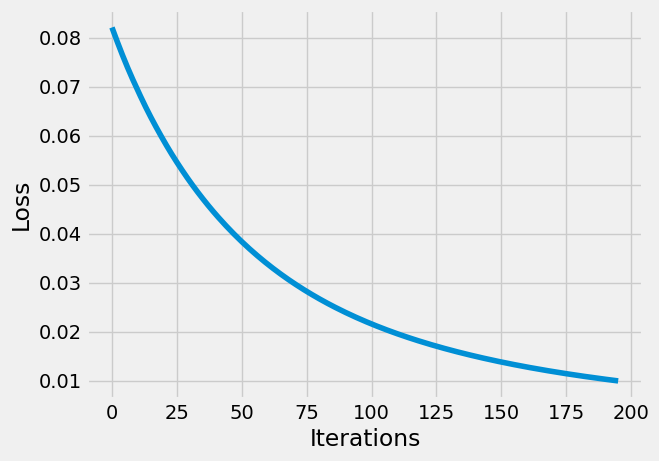

In [34]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
         
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=1, padding="same"),
            nn.Flatten(),
            # nn.Linear(128*9, 128 * 9),
            # nn.Tanhshrink(),
            # nn.Sigmoid(),
            # nn.Linear(128*9, 128),
            # nn.ReLU(),
            # nn.Linear(128, 64),
            # nn.ReLU(),
            # nn.Linear(64, 36),
            # nn.ReLU(),
            # nn.Linear(36, 18),
            # nn.ReLU(),
            # nn.Linear(18, 9)
        )
         
        self.decoder = nn.Sequential(
            # nn.Linear(9, 18),
            # nn.ReLU(),
            # nn.Linear(18, 36),
            # nn.ReLU(),
            # nn.Linear(36, 64),
            # nn.ReLU(),
            # nn.Linear(64, 128),
            # nn.ReLU(),
            nn.Linear(128 * 9, 128 * 9),
            nn.Tanhshrink(),
            # nn.Sigmoid(),
            # nn.Linear(128, 128 * 9),
            # nn.Sigmoid(),
            nn.Unflatten(1, (1, 128, 9))
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = AE()
cuda0 = torch.device('cuda:0')

x_gpu = x[:100].to(cuda0)
# add dimension
x_gpu = torch.unsqueeze(x_gpu, 1)
model_gpu = model.to(cuda0)
 
loss_function = torch.nn.MSELoss()
 
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-2)
                            #  weight_decay = 1e-8)
scheduler = ReduceLROnPlateau(optimizer, factor=0.9, threshold=1e-4, patience=100)

epochs = 10000
outputs = []
losses = []
for epoch in range(epochs):
       
    #   # Reshaping the image to (-1, 784)
    #   image = image.reshape(-1, 28*28)
       
    # Output of Autoencoder
    reconstructed = model_gpu(x_gpu)
    
    # Calculating the loss function
    loss = loss_function(reconstructed, x_gpu)
    
    # The gradients are set to zero,
    # the gradient is computed and stored.
    # .step() performs parameter update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Storing the losses in a list for plotting
    l = loss.cpu().detach().numpy()
    losses.append(l)

    scheduler.step(l)
    lr = optimizer.param_groups[0]['lr']
    print(l, lr)
    del reconstructed
    del loss

    if lr < 1e-5 or l < 0.01:
        print("break at", epoch)
        break
    # audio = spectrogrammer.mel2wave(model(x[0:1]))
    # Audio(audio.numpy(), sample_rate=SAMPLE_RATE)
 
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the last 100 values
plt.plot(losses[100:])

In [6]:
next(model.parameters()).device

device(type='cuda', index=0)

In [10]:
del scheduler

In [37]:
with torch.no_grad():
    x_pred = model(x_gpu)
x_pred = torch.squeeze(x_pred, dim=1)
print(x_pred.shape)
wave_pred = spectrogrammer.mel2wave_with_phase(x_pred[0], wavs[0])
display(Audio(wave_pred.cpu().numpy(), rate=SAMPLE_RATE))

torch.Size([100, 128, 9])


In [45]:
Audio(wavs[0].cpu().numpy() - wave_pred.cpu().numpy(), rate=SAMPLE_RATE)

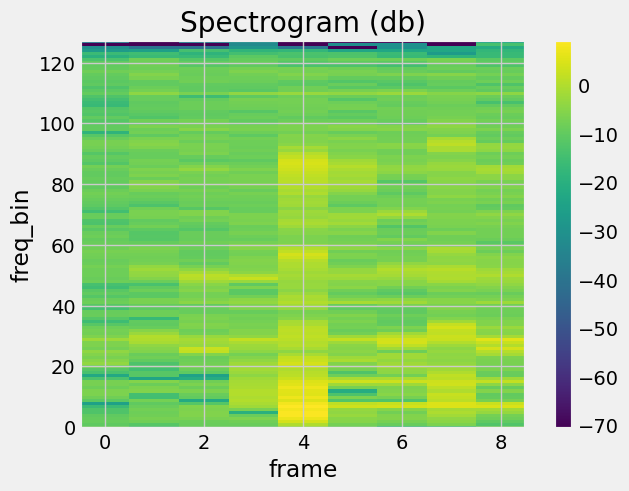

In [38]:
plot_spectrogram(x_pred[0].cpu().numpy())

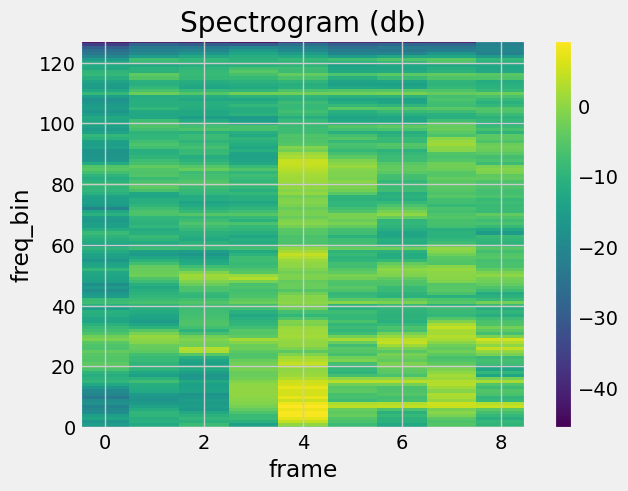

In [39]:
plot_spectrogram(x[0].cpu().numpy())

In [46]:
display(Audio(wavs[0], rate=SAMPLE_RATE))
wave = spectrogrammer.mel2wave(x[0])
display(Audio(wave.numpy(), rate=SAMPLE_RATE))

In [150]:
model = model_gpu.to("cpu")
x_pred = model(x)
wave_pred = spectrogrammer.mel2wave(x_pred)
wave_pred.shape

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [154]:
spectrogrammer.mel2wave(x).shape

KeyboardInterrupt: 

In [91]:
tensor

tensor([[-0.2018,  0.0599],
        [ 0.2664,  1.5481]])

In [55]:
torch.__version__

'1.12.1+cu116'

In [ ]:
for epoch in range(epochs):
    for i in x:
       
    #   # Reshaping the image to (-1, 784)
    #   image = image.reshape(-1, 28*28)
       
      # Output of Autoencoder
      reconstructed = model(x)
       
      # Calculating the loss function
      loss = loss_function(reconstructed, x)
       
      # The gradients are set to zero,
      # the gradient is computed and stored.
      # .step() performs parameter update
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
       
      # Storing the losses in a list for plotting
      losses.append(loss)
      print(loss)
    outputs.append((epochs, image, reconstructed))